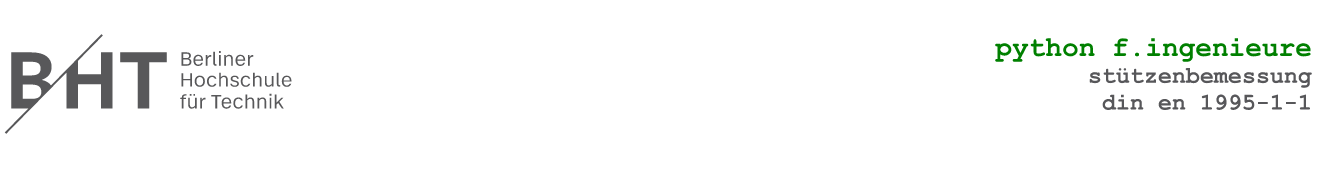

# Anwendungsbeispiel 1: Stützenbemessung 

## Stabilitätsnachweis nach der Theorie II. Ordnung

Vor allem bei Stützen können baupraktisch unvermeidbare Imperfektionen und Vorverformungen zu einer Knickgefährdung des Tragwerks führen, sodass die Betrachtung des Gleichgewichts am verformten System maßgeblich sein kann. Als Alternative zur Bemessung mit dem Ersatzstabverfahren wird die Tragfähigkeit nach der Theorie II. Ordnung (auch p-Delta Verfahren)  nachgewiesen, indem mit einer Vorverformung das Gleichgewichtssystem aufgestellt wird. Bei nichtlinearer Schnittgrößenermittlung kann jedoch zur Vereinfachung weiterhin das linear-elastische Materialverhalten als Idealisierung herangezogen werden (vgl. Neuhaus 2017: 821).

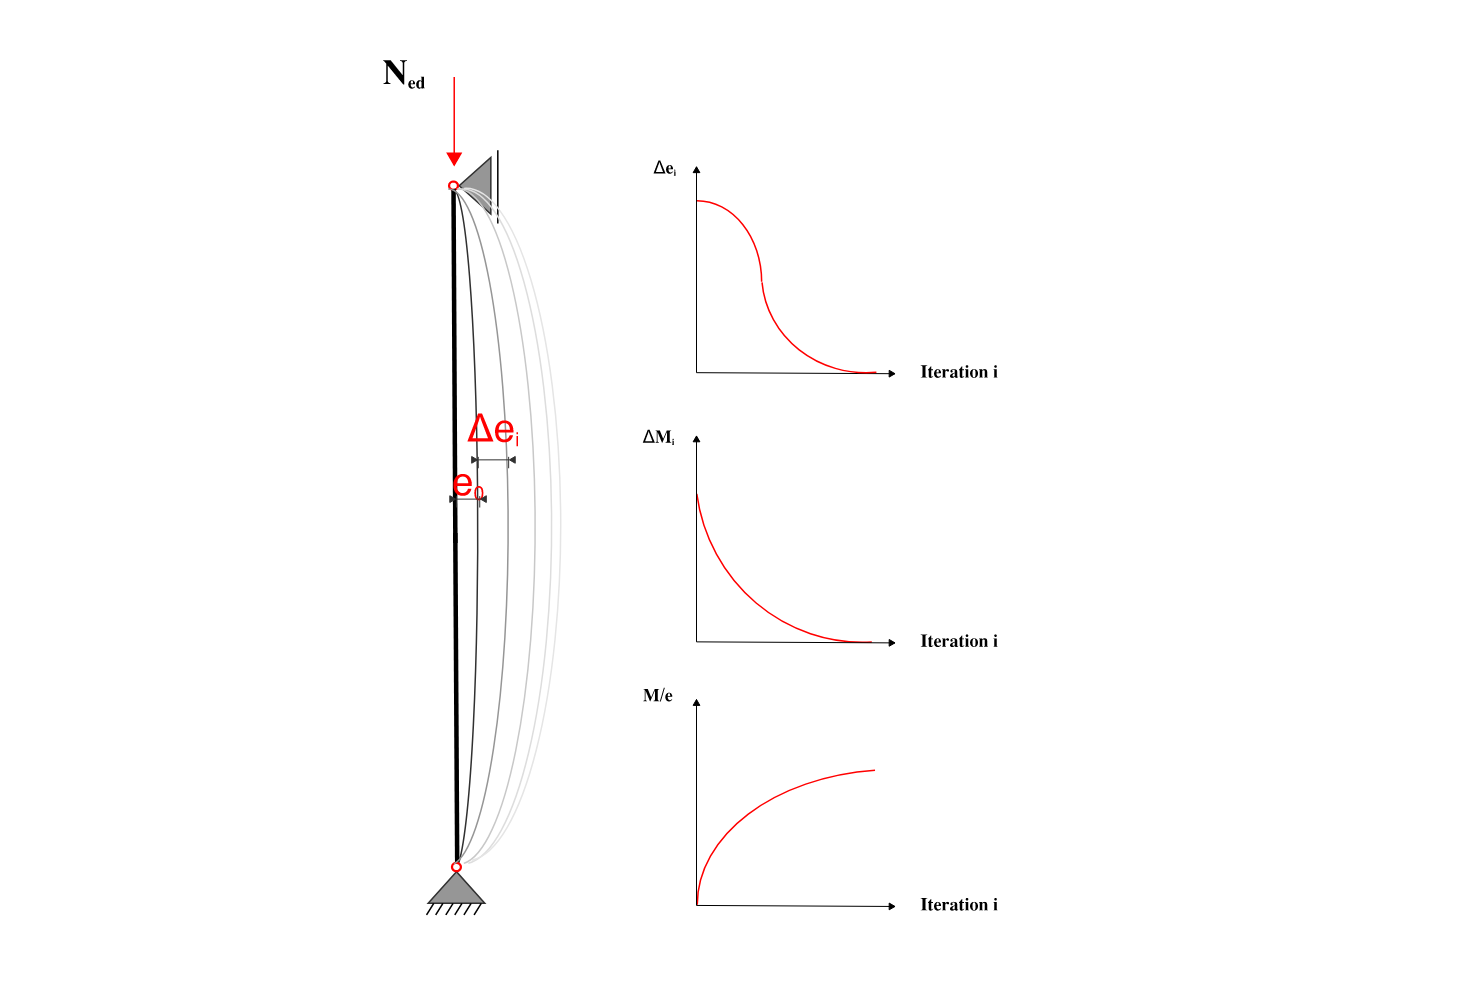
<center> Abbildung 1: Stützenbemessung nach der Theorie II. Ordnung</center> <br>

Das Angreifen der Last am verformten System führt durch die Exzentrizität zu einer Biegebeanspruchung, die wiederum zu einer zusätzlichen Auslenkung führt und das Moment überproportional ansteigen lässt. Dieses geometrisch nichtlineare Verhalten erfordert bei der Berechnung einen iterativen Ansatz, welcher mit Python gut lösbar ist. Die Stützenbemessung nach der Theorie II. Ordnung wird anhand des Beispiels fortgeführt.

### Eingangswerte

#### Bibliotheken

In [1]:
from math import sqrt, pi           #Mathematische Funktionen
import matplotlib.pyplot as plt     #Erstellen von Grafiken
import pandas as pd                 #Erstellen von Tabellen
import handcalcs.render             #Darstellung formattierter Gleichungen

#### System

In [2]:
%%render
Lagerung = 'Pendelstütze'

<IPython.core.display.Latex object>

#### Geometrie

In [3]:
%%render params 1
L = 3.6    #m - Länge
b = 0.6  #m - Breite
h = 0.6  #m - Höhe

<IPython.core.display.Latex object>

#### Bemessungswerte der Einwirkung

In [4]:
%%render params 1
N_ed = 2400 #kN - Normalkraft
M_yd = 30    #kNm - Moment um y-Achse
M_zd = 40    #kNm - Moment um z-Achse

<IPython.core.display.Latex object>

#### Charakteristische Festigkeitswerte

In [5]:
%%render params 1
Güte = 'GL24h'      #Holzgüte
f_c0k = 24*1000     #$kN/m^2$ - Druck  
f_myk = 24*1000     #$kN/m^2$ - Biegung
f_mzk = 24*1000     #$kN/m^2$ - Biegung
E_0mean = 11500*1000   #$kN/m^2$ - E-Modul  

<IPython.core.display.Latex object>

#### Widerstandsbeiwerte

In [6]:
%%render
k_mod = 0.6      #Modifikationsbeiwert
gamma = 1.3      #Teilsicherheitsbeiwert
xi = k_mod/gamma #Abminderungsbeiwert

<IPython.core.display.Latex object>

### Berechnung

#### Querschnittsparameter

In [7]:
%%render params 3
A = b*h #$m^2$ - Querschnitt

<IPython.core.display.Latex object>

In [8]:
%%render params 5
I_y = (b*h**3)/12  #$m^4$ - FTM
w_y = (b*h**2)/6   #$m^3$ - Widerstandsmoment
i_y = h/sqrt(12)   #$m$ - polares Trägheitsmoment


I_z = (h*b**3)/12  #$m^4$ - FTM
w_z = (h*b**2)/6   #$m^3$ - Widerstandsmoment
i_z = b/sqrt(12)   #$m$ - polares Trägheitsmoment

<IPython.core.display.Latex object>

#### Systembeiwerte

Nach der DIN EN 1995-1-1 Abs. 5.4.3 ist für seitlich unverschiebliche Systeme eine Vorverformung $\theta = 1/400$ anzusetzen.

Das selbe kann nun für die Bestimmung des $\beta$-Wertes erfolgen.

In [10]:
#Definition des Systems
system = 'Pendelstütze'

#if-Abfrage zur Bestimmung von beta
if system == 'Pendelstütze':
    beta = 1
elif system == 'Kragstütze':
    beta = 2
elif system == 'Eingespannt (u/o)':
    beta = 0.7
else:
    beta = 0.5

l_ef = beta*L #m - Knicklänge

#### Bemessungswerte der Festigkeit

In [11]:
%%render
f_c0d = f_c0k*xi #$N/mm^2$ - Bemessungswert der Druckfestigkeit
f_myd = f_myk*xi #$N/mm^2$ - Bemessungswert der Biegefestigkeit
f_mzd = f_mzk*xi #$N/mm^2$ - Bemessungswert der Biegefestigkeit
E_0meand =E_0mean/gamma #$N/mm^2$ - Bemessungswert der Biegefestigkeit

<IPython.core.display.Latex object>

### Vorgehensweise nach EC5 
Die Vorgehensweise der iterativen Ermittlung der Schnittgrößen ist wie folgt:
<br>

**Theorie I. Ordnung** <br>

Zunächst wird anhand des vorgegebenen Imperfektionsbeiwertes die ungewollte Ausmitte der Stütze ermittelt und führt zum Moment infolge der Vorverkrümmung. Mit dem einwirkenden Moment um die y- oder z-Achse ergibt sich das Gesamtmoment nach Theorie I.Ordnung.

1. Vorverkrümmung
 $$e_0 = \theta*L$$
2. Moment infolge Vorverkrümmung
 $$M_0 = e_0*N_{ed}$$
3. Gesamtmoment
 $$M = M_0+M_{ed}$$
 
**Iteration nach Theorie II. Ordnung** <br>

Die Schnittgrößenermittlung nach Theorie II. Ordnung erfolgt mit der Formel für die Durchbiegung eines Einfeldbalkens. Abhängig ist die Verformung von der Länge und Biegesteifigkeit des Stabes. Mit der ermittelten Verformung errechnet sich das Moment nach Theorie II. Ordnung. Um die Iteration fortzuführen, wiederholt man diesen Vorgang mit dem neu gerechneten Moment, bis die zusätzliche Verformung gegen Null konvergiert.

4. Verformung infolge zusätzlichem Moment
 $$e_i = \frac{M_i*L^2}{E*I*\pi^2}$$
5. Moment infolge zusätzlicher Verformung
 $$M_i = e_i*N_{ed}$$
 
**Ergebnis** <br>

Das Ergebnis der Schnittgrößenermittlung nach Theorie II. Ordnung ergibt sich aus der Summe der Momente. 

6. Gesamtverformung
 $$e_{tot} = e_0 + \sum e_i$$
7. Gesamtmoment
 $$M_{tot} = M_0 + \sum M_i$$

### Vorgehensweise in Python
#### Iterationsanweisung
Eines der größten Vorteile eines Computers ist die hohe Rechenleistung und damit einhergehend die hohe Geschwindigkeit, wodurch Rechenaufgaben tausendfach in wenigen Sekunden berechnet werden können.
Diesen Vorteil kann man besonders zum Einsatz bringen, wenn diese Rechenaufgaben in einer Schleife verpackt werden, in denen bestimmte Vorgänge automatisch wiederholt werden.

**Schema**

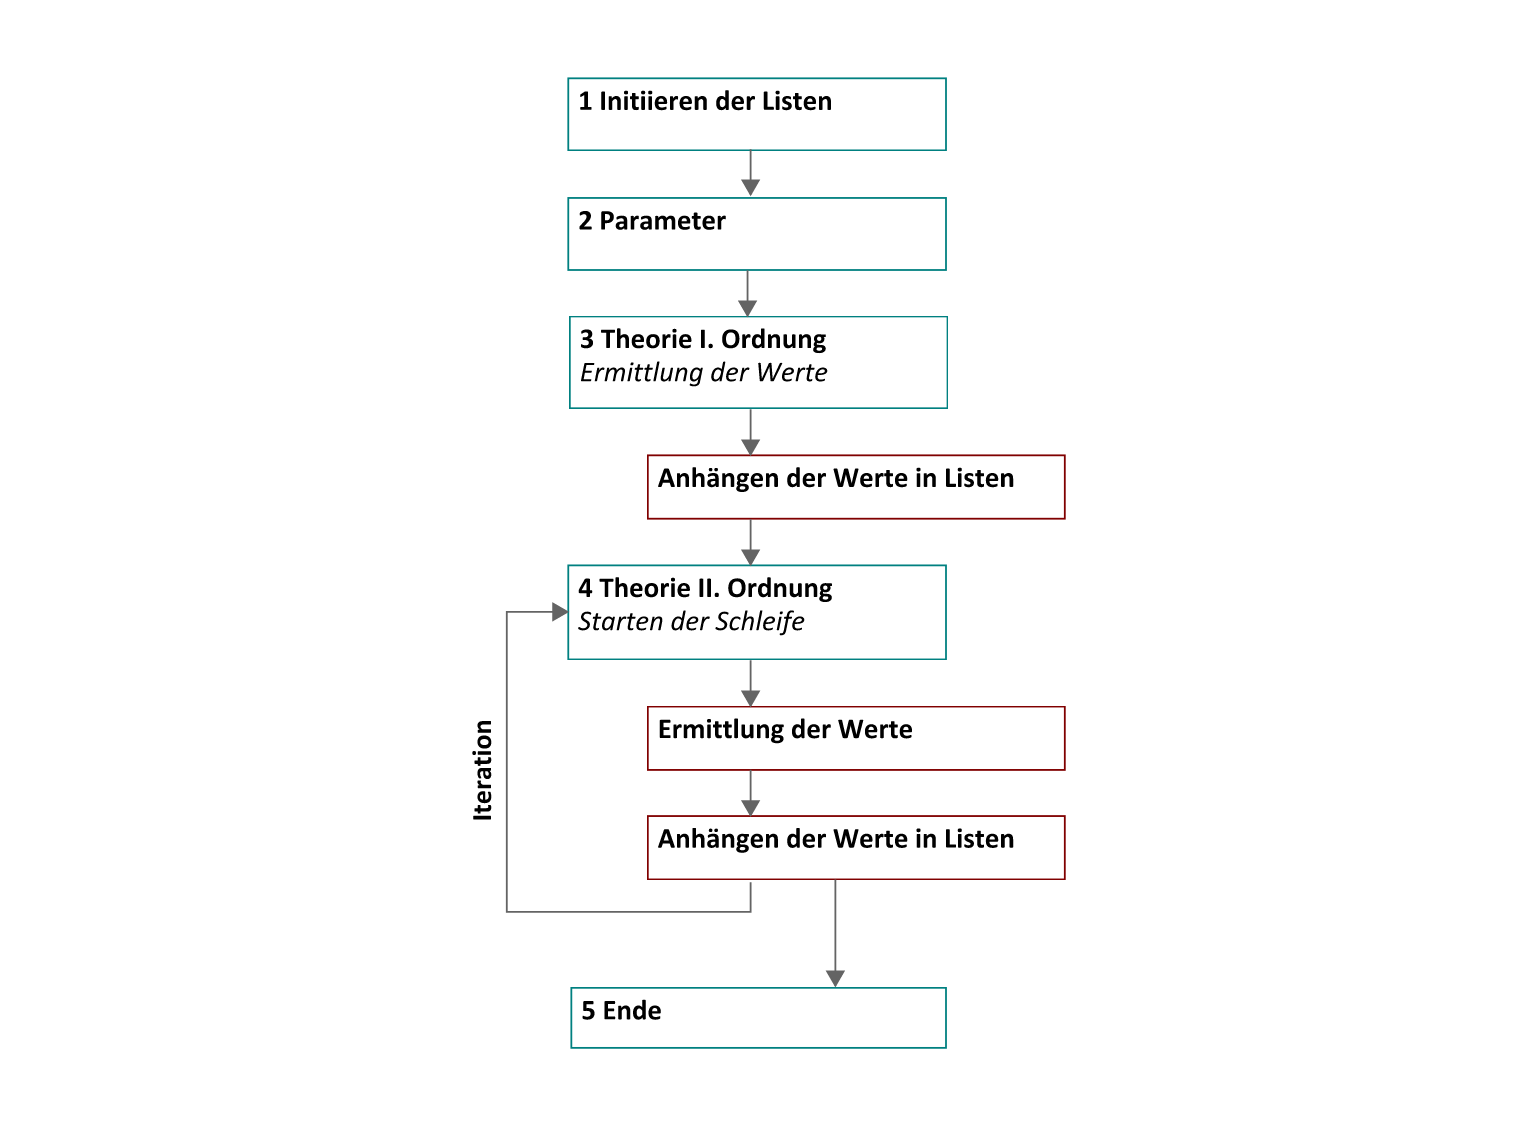
<center> Abbildung 2: Schema zum Iterationsvorgang</center> <br>

Analog dazu soll die Umsetzung in Python angeführt werden. Auch hier wird zunächst nur ein Iterationsschritt gezeigt. Um die verschiedenen Ergebnisse zu speichern, müssen zunächst Listen erstellt werden, in denen sie mit der ```append()```-Funktion beigefügt werden.

0. Initiieren der Listen 


```Python 
                                                    L_e = []
                                                    L_M = [] 
                                                    L_e_total = []
                                                    L_M_total = []
```

**Theorie I. Ordnung**
1. Vorverkrümmung
```Python 
                                                    e_0 = theta*L
```
2. Moment infolge Vorverkrümmung
```Python 
                                                    M_0 = e_0*N_ed
```
3. Gesamtmoment
```Python 
                                                    M = M_0+M_ed
```
4. Anhängen der Werte in Listen
```Python 
                                                    L_M.append(M)
                                                    L_e.append(e_0)
```
 
**Theorie II. Ordnung** <br>

Die Momente werden in der Liste ```L_M``` gespeichert. Mittels ```L_M[i]``` wird auf das zuletzt hinzugefügte Moment zugegriffen.

5. Verformung infolge zusätzlichem Moment
```Python 
                                                    e_i = (L_M[i]*L**2)/(E*I*math.pi**2)
```

6. Moment infolge zusätzlicher Verformung
```Python 
                                                    M_i = e_i*N_ed
```

7. Anhängen der Werte in Listen
```Python 
                                                    L_e.append(e_i)
                                                    L_M.append(M_i)
```
**Ergebnis** <br>

Für die Ermittlung der Gesamtverformung und -moment wird mit der ```sum()```-Funktion die Summe der Listen gebildet.

8. Gesamtverformung
```Python 
                                                    e_total = sum(L_e)
                                                    L_e_total.append(e_total)
```
9. Gesamtmoment
```Python 
                                                    M_total = sum(L_M)
                                                    L_M_total.append(M_total)
```


In [12]:
#Initiieren der Listen
L_M = []
L_e = []
L_e_total = []
L_M_total = []

#Theorie I. Ordnung
##Ermittlung der Werte
e_0 = theta*L
M_0 = e_0 * N_ed
M = M_yd

##Anhängen der Werte in Listen
L_e.append(round(e_0*1000,1))
L_M.append(round(M,1))
e_total = sum(L_e)
M_total = sum(L_M)
L_e_total.append(e_total)
L_M_total.append(M_total) 
   
#Theorie II. Ordnung
## Iteration 1
###Ermittlung der Werte
e_1 = (M*L**2)/(E_0meand*I_y*pi**2)
M_1 = e_1 * N_ed

###Anhängen der Werte in Listen
L_e.append(round(e_1*1000,1))
L_M.append(round(M_1,1)) 
e_total = sum(L_e)
M_total = sum(L_M)
L_e_total.append(e_total)
L_M_total.append(M_total) 

## Iteration 2
###Ermittlung der Werte
e_2 = (M_1*L**2)/(E_0meand*I_y*pi**2)
M_2 = e_2 * N_ed

###Anhängen der Werte in Listen
L_e.append(round(e_2*1000,1))
L_M.append(round(M_2,1))
e_total = sum(L_e)
M_total = sum(L_M)
L_e_total.append(e_total)
L_M_total.append(M_total) 
 
## Iteration 3
###Ermittlung der Werte
e_3 = (M_2*L**2)/(E_0meand*I_y*pi**2)
M_3 = e_3 * N_ed

###Anhängen der Werte in Listen
L_e.append(round(e_3*1000,1))
L_M.append(round(M_3,1))
e_total = sum(L_e)
M_total = sum(L_M)
L_e_total.append(e_total)
L_M_total.append(M_total)     

### Iteration (als Schleife)
Die Wiederholung der Iterationen soll nun in einer Schleife ausgeführt werden. Mit der Definition der Variable ```no_iter``` kann die Anzahl der Iterationen bestimmt werden. 

Es ist nun darauf zu achten, dass die Wertereihe bei 0 anfängt und somit der Wert der Zahl um eine Zahl versetzt ist. Daher muss der Bereich für die Iteration entsprechend mit n-1 angepasst werden. Geschieht dies nicht, erscheint eine Fehlermeldung, da die Schleife somit ins Leere laufen würde.

Zusätzlich soll als Nächstes eine weitere Schleife integriert werden, die nacheinander die Iterationsberechnung für das Moment um die y-Achse und um die z-Achse durchführt. Wieder soll der Code so geschrieben werden, dass er allgemeingültig für alle Fälle anwendbar ist. 


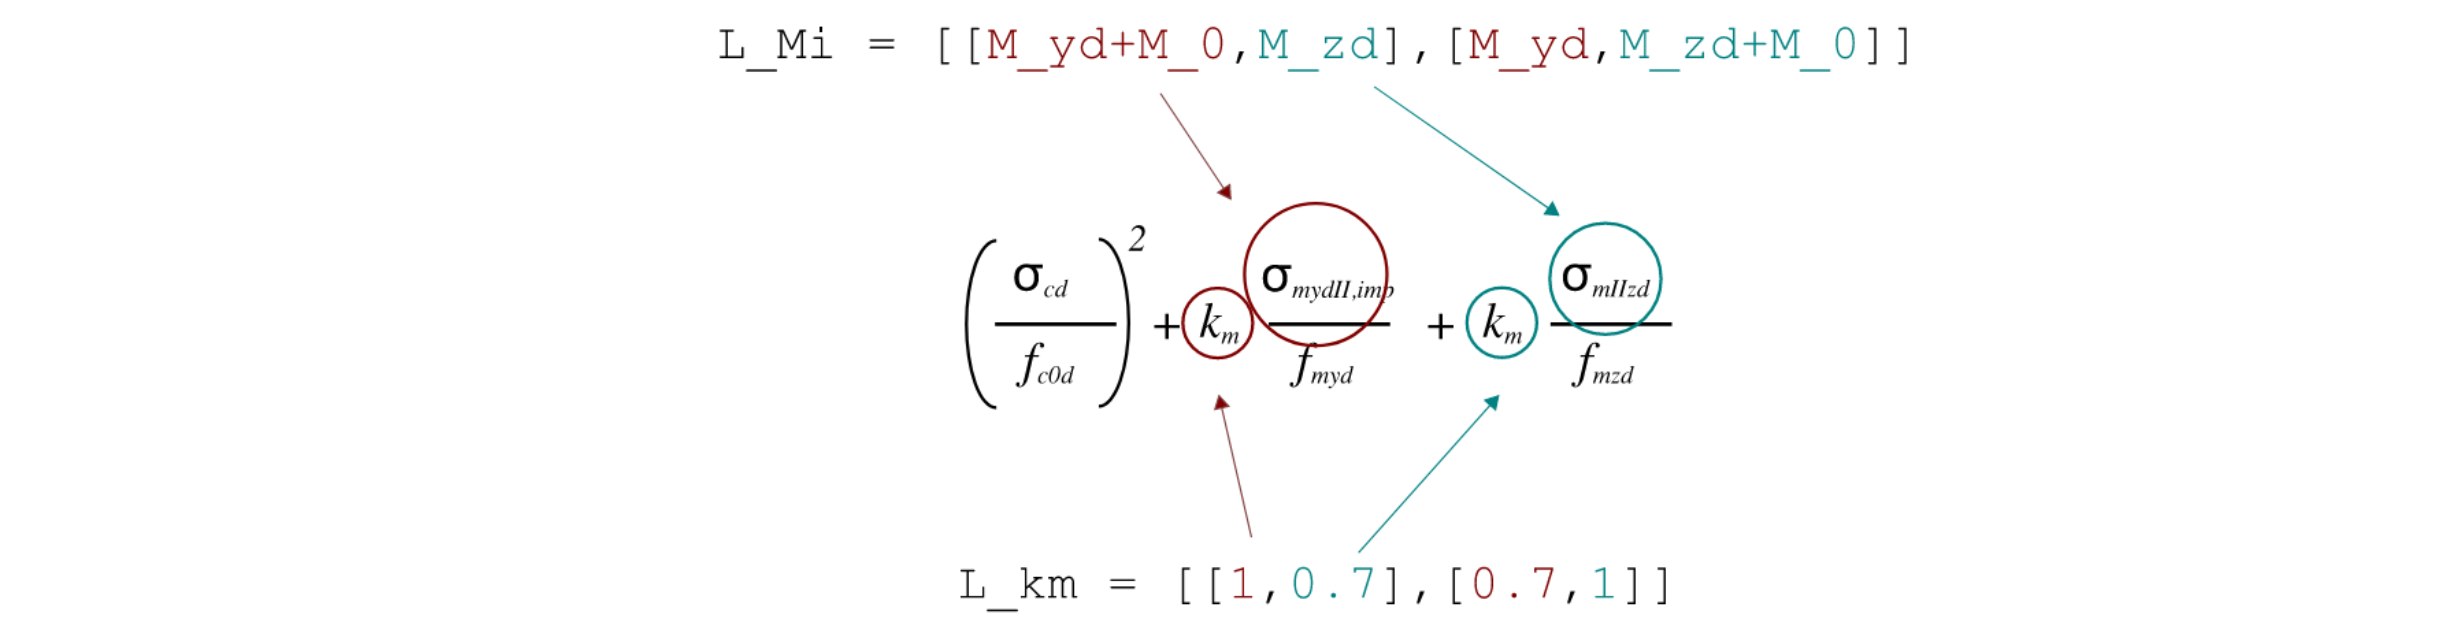

Der Nachweis erfolgt nach der DIN EN 1995-1-1 Abs. 6.2.4 als Biegespannungsnachweis. 
Bei zweiaxialer Biegebeanspruchung ist die Vorverformung nur an der ungünstigen Achse anzusetzen. Um dies zu gewährleisten, muss gleichzeitig der km-Beiwert mit der Spannung multipliziert werden, bei der nicht die Vorverformung angesetzt wurde. Um dies im Code widerzuspiegeln, werden alle Parameter analog zu Kapitel 3.2.3.6 in verschachtelten Listen gespeichert, um alle Berechnungen strukturiert durchzuführen.

Die Ergebnisse werden mit einem **pandas-DataFrame** als Tabelle dargestellt.
Anhand drei Iterationsschritten ist bereits erkennbar, dass die zusätzliche Verformung ```e_i``` und Moment ```M_i``` abnimmt und die Gesamtergebnisse zunehmen. 

In [13]:
#Beiwert k_m
if M_yd == 0 or M_zd == 0:
    L_km = [[1,1],[1,1]]
else:
    L_km = [[1,0.7],[0.7,1]]
    
#Listen
L_bh = [[b,h],[h,b],[b,h],[h,b]]
L_e = [[e_0*1000],[0],[0],[e_0*1000]]
L_M = [[M_yd+M_0],[M_zd],[M_yd],[M_zd+M_0]]
L_e_total = [[e_0],[0],[0],[e_0]]
L_M_total = [[M_yd+M_0],[M_zd],[M_yd],[M_zd+M_0]]
L_sigma_mIId = []
L_Mi = [M_yd+M_0, M_zd, M_yd, M_zd+M_0]

#Schleife 1: Schnittgrößenermittlung nach Theorie II. Ordnung
for n in range(4):

    ##Querschnittsparameter
    A = b*h                            #$m^2$ 
    I = (L_bh[n][0]*L_bh[n][1]**3)/12  #$m^4$ - FTM
    w = (L_bh[n][0]*L_bh[n][1]**2)/6   #$m^3$ - Widerstandsmoment
    i = L_bh[n][1]/sqrt(12)            #$m$ - polares Trägheitsmoment

    ##Theorie II. Ordnung
    #Schleife 2
    for i in range(5):  

        ##Ermittlung der Werte
        e_i = (L_M[n][i]*l_ef**2)/(E_0meand*I*pi**2)
        M_i = e_i * N_ed

        ##Anhängen der Werte in Listen
        L_e[n].append(round(e_i*1000,1))
        L_M[n].append(round(M_i,2)) 
        e_total = sum(L_e[n])
        M_total = sum(L_M[n])
        L_e_total[n].append(round(e_total,2))
        L_M_total[n].append(round(M_total,2))

    #Spannungen
    sigma_mIId = L_M_total[n][-1]/w #$kN/m^2$
    L_sigma_mIId.append(round(sigma_mIId,2))

#Ergebnisse in Listen
##Verformungen und Momente
L_e_res = [[L_e[0][-1], L_e[1][-1]], [L_e[2][-1], L_e[3][-1]]]
L_M_res = [[L_M[0][-1], L_M[1][-1]], [L_M[2][-1], L_M[3][-1]]]
L_e_total_res = [[L_e_total[0][-1], L_e_total[1][-1]], [L_e_total[2][-1], L_e_total[3][-1]]]
L_M_total_res = [[L_M_total[0][-1], L_M_total[1][-1]], [L_M_total[2][-1], L_M_total[3][-1]]]

##Spannungen nach Theorie II. Ordnung
sigma_cd = N_ed/A
sigma_myIId_imp = L_sigma_mIId[0]
sigma_mzIId = L_sigma_mIId[1]
sigma_myIId = L_sigma_mIId[2]
sigma_mzIId_imp = L_sigma_mIId[3]
L_sigma_mIId = [[sigma_myIId_imp, sigma_mzIId], [sigma_myIId, sigma_mzIId_imp]]

Lässt man nach dem Durchlaufen der Schleife die Liste ```L_M_total``` ausgeben, sieht man die verschachtelte Struktur der Liste. Auf diese Weise sind gemäß der zuvor definierten Anordnung der Vorverformungen die Unterschiede der Gesamtmomente erkennbar.

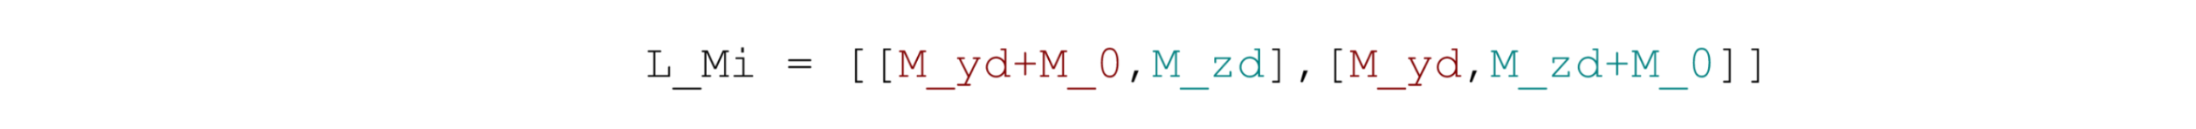

### Grafische Auswertung der Ergebnisse
#### Tabelle

**pandas DataFrame** <br>
Für das Visualisieren der Ergebnisse werden zunächst Tabellen erstellt. 

Die übersichtlichste Art der Darstellung von Tabellen kann mit Hilfe von ***DataFrames*** erfolgen. Ein DataFrame ist ein Datentyp der Bibliothek ***Pandas*** und beinhaltet eine geordnete Sammlung an Spalten. Es ist somit eine tabellarische Datenstruktur, die es ermöglicht Datensätze formatiert in Python darzustellen.

Für die Erstellung eines DataFrames muss zunächst ein ***Dictionary*** mit den Spaltennamen und -daten definiert werden (1). Das Dictionary wird dann in das Objekt DataFrame als Argument zugeordnet (2). Die Ergebnisse wurden in der Schleife in Listen gespeichert, sodass diese mit dem jeweiligen Index zugegriffen werden können. Anhand der Listen können dann für die y- und z-Richtung jeweils Dictionaries erstellt werden. 

**Dictionaries** <br>
Diese Form der Datenstruktur stellt eine unsortierte Menge von Schlüssel-Wert-Paaren dar. Ein Dictionary wird einer Variablen zugeordnet und mit einer geschweiften Klammer initiiert. Innerhalb der Klammer werden Schlüssel und Wert als string und einem Doppelpunkt definiert.

```Python
dict = {
  "hersteller": "Würth",
  "schraubenart": "Vollgewinde",
  "durchmesser": 8,
  "länge": 200
}

dict['hersteller'] = 'Spax'
```

Zugegriffen kann dann auf den Wert für den Schlüssel 'hersteller' analog zu den Listen mit einer eckigen Klammer.

**Das Python-Tutorial** <br>
[Weiteres zu Datenstrukturen](https://py-tutorial-de.readthedocs.io/de/python-3.3/datastructures.html)<br>

In der folgenden Tabelle sind die Ergebnisse der Schnittgrößenermittlung nach der Theorie II. Ordnung dargestellt. Mit der Variablen ```no_iter = 5``` wurde die Anzahl der Iterationsschritte festgelegt. Da in der Informatik die Zahlenreihe bei 0 beginnt, entspricht dies 6 Iterationen. In den ersten beiden Spalten nach den Indices sind die Werte für die Zusatzverformung und dem resultierenden Moment dargestellt. Hier ist erkennbar, dass bereits nach 4 Schritten die Werte gegen 0 konvergieren. Die Spalten 3 und 4 beinhalten die aufsummierten Werte.

**um y-Achse** <br>
Um y-Achse: mit Vorverformung (um y-Achse), um z-Achse: ohne Vorverformung

In [14]:
#um y-Achse
##Erstellen eines Dictionaries (1)
dict_y = {"Δey [mm]": L_e[0], "ΔMy [kNm]": L_M[0], "∑ey [mm]": \
   L_e_total[0], "∑My [kNm]": L_M_total[0]}

#Erstellen eines DataFrames
df_y = pd.DataFrame(dict_y)

#Anzeigen des DataFrames
display(df_y)


#um z-Achse
##Erstellen eines Dictionaries
dict_z = {"Δez [mm]": L_e[1], "ΔMz [kNm]": L_M[1], "∑ez [mm]": \
          L_e_total[1], "∑Mz [kNm]": L_M_total[1]}

#Erstellen eines DataFrames
df_z = pd.DataFrame(dict_z)

#Anzeigen des DataFrames
display(df_z)

,Δey [mm],ΔMy [kNm],∑ey [mm],∑My [kNm]
0,9.0,51.60,0.009,51.60
1,0.7,1.70,9.700,53.30
2,0.0,0.06,9.700,53.36
3,0.0,0.00,9.700,53.36
4,0.0,0.00,9.700,53.36
5,0.0,0.00,9.700,53.36


,Δez [mm],ΔMz [kNm],∑ez [mm],∑Mz [kNm]
0,0.0,40.00,0.0,40.00
1,0.5,1.32,0.5,41.32
2,0.0,0.04,0.5,41.36
3,0.0,0.00,0.5,41.36
4,0.0,0.00,0.5,41.36
5,0.0,0.00,0.5,41.36


**um z-Achse** <br>
Um y-Achse: ohne Vorverformung (um y-Achse), um z-Achse: mit Vorverformung

In [15]:
#um y-Achse
##Erstellen eines Dictionaries (1)
dict_y = {"Δey [mm]": L_e[2], "ΔMy [kNm]": L_M[2], "∑ey [mm]": \
   L_e_total[2], "∑My [kNm]": L_M_total[2]}

#Erstellen eines DataFrames
df_y = pd.DataFrame(dict_y)

#Anzeigen des DataFrames
display(df_y)


#um z-Achse
##Erstellen eines Dictionaries
dict_z = {"Δez [mm]": L_e[3], "ΔMz [kNm]": L_M[3], "∑ez [mm]": \
          L_e_total[3], "∑Mz [kNm]": L_M_total[3]}

#Erstellen eines DataFrames
df_z = pd.DataFrame(dict_z)

#Anzeigen des DataFrames
display(df_z)

,Δey [mm],ΔMy [kNm],∑ey [mm],∑My [kNm]
0,0.0,30.00,0.0,30.00
1,0.4,0.99,0.4,30.99
2,0.0,0.03,0.4,31.02
3,0.0,0.00,0.4,31.02
4,0.0,0.00,0.4,31.02
5,0.0,0.00,0.4,31.02


,Δez [mm],ΔMz [kNm],∑ez [mm],∑Mz [kNm]
0,9.0,61.60,0.009,61.60
1,0.8,2.03,9.800,63.63
2,0.0,0.07,9.800,63.70
3,0.0,0.00,9.800,63.70
4,0.0,0.00,9.800,63.70
5,0.0,0.00,9.800,63.70


**Zusammenstellung**

In [16]:
#um z-Achse
##Erstellen eines Dictionaries
dict_m = {"y (Imp)": [L_M_total[0][-1], L_sigma_mIId[0][0]], "z ": [L_M_total[1][-1], L_sigma_mIId[0][1]], "y ": \
          [L_M_total[2][-1], L_sigma_mIId[1][0]], "z (Imp)": [L_M_total[3][-1], L_sigma_mIId[1][1]]}
index = ['M [kNm]', 'σ [kNm2]']
#Erstellen eines DataFrames
df_m = pd.DataFrame(dict_m, index=index)

display(df_m)

,y (Imp),z,y,z (Imp)
M [kNm],53.36,41.36,31.02,63.70
σ [kNm2],1482.22,1148.89,861.67,1769.44


#### Grafik
Mit Hilfe der Standardbibliothek matplotlib können Ergebnisse mit wenig Aufwand als Grafiken dargestellt werden. Nachdem die Bibliotheken importiert wurden, werden im ersten Schritt die Werte für die x- und y-Achsen definiert. Ziel dieser Darstellung soll es sein, zwei Liniendiagramme zu erstellen, die die Zusatzverformungen e_i und die Gesamtverformungen e_tot untereinander darstellen. Die y-Werte werden wieder aus der Liste entnommen. Für die x-Achse wird mit dem Modul numpy eine passende Zahlenanordnung erstellt. Die Funktion enthält 3 Argumente: 
```python
np.arange(start, stop, schritte)
```
Das Erstellen von Grafiken erfolgt grundsätzlich immer nach demselben Schema. Im ersten Schritt wird ein leerer Plot erzeugt, der anschließend mit Informationen für die Achsen und für die Beschriftungen gefüllt wird. Bei der Darstellung von mehreren Grafiken muss die Funktion ```plt.subplot()``` mit der Zahl 211 für die Anzahl der Zeilen, Spalten und Nummer der aktuellen Grafik definiert werden.
```python
plt.subplot(Zeilen, Spalten, Nummer)
```

```Python

np.arange(start, stop, schritte)

```

**Verformungen** <br>

Text(0.5, 1.0, 'Verformung $\\sum e_i$')

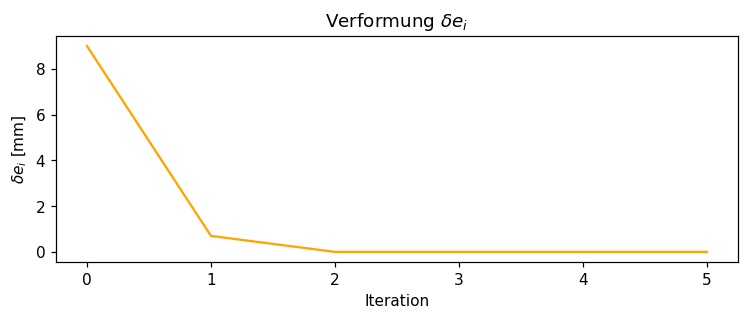

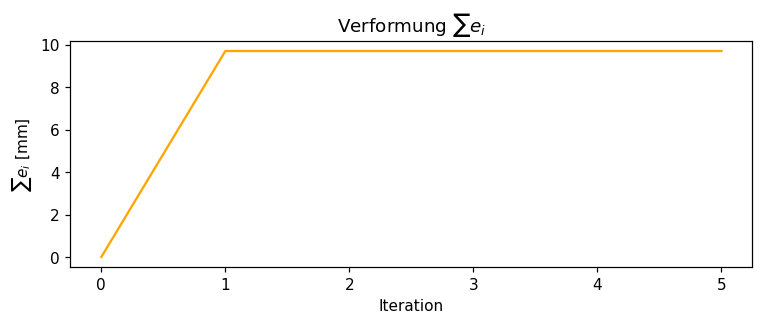

In [17]:
#Daten für x- und y-Achsen
x = np.arange(0, 6, 1)
y1 = L_e[0]
y2 = L_e_total[0]

#Plot 1: Verformung e_i
plt.figure(figsize=(8, 6), dpi=110)    #Initiieren eines Plots
plt.subplot(211)                       #Zeilen, Spalten, Nummer
plt.plot(x, y1,'orange')               #Einfügen der Daten
plt.ylabel('$\delta e_i$ [mm]')        #Beschriftung der y-Achse
plt.xlabel('Iteration')                #Beschriftung der x-Achse
plt.title('Verformung $\delta e_i$')   #Titel

#leerer Plot als Abstandhalter
plt.figure(figsize=(8, 6), dpi=110)
plt.plot('', '', '')

#Plot 2:Summe der Verformungen e_i
plt.subplot(212)                       #Zeilen, Spalten, Nummer
plt.plot(x, y2, 'orange')              #Einfügen der Daten
plt.ylabel('$\sum e_i$ [mm]')          #Beschriftung der y-Achse
plt.xlabel('Iteration')                #Beschriftung der x-Achse
plt.title('Verformung $\sum e_i$')     #Titel

**Momente** <br>

Text(0.5, 1.0, 'Moment $\\sum M_i$')

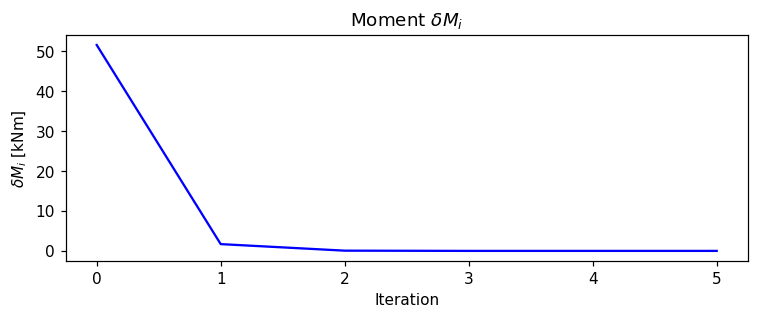

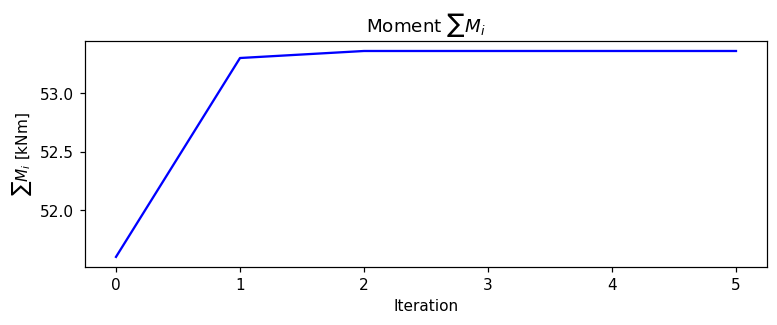

In [18]:
**Verformungen** <br>#Daten für x- und y-Achsen
x = np.arange(0, 6, 1)
y1 = L_M[0]
y2 = L_M_total[0]

#Verformung e_i
plt.figure(figsize=(8, 6), dpi=110)
plt.subplot(211)
plt.plot(x, y1,'blue')
plt.ylabel('$\delta M_i$ [kNm]')
plt.xlabel('Iteration')
plt.title('Moment $\delta M_i$')

#Abstandhalter
plt.figure(figsize=(8, 6), dpi=110)
plt.plot('', '', '')

#Summe der Verformungen e_i
plt.subplot(212)
plt.plot(x, y2, 'blue')
plt.ylabel('$\sum M_i$ [kNm]')
plt.xlabel('Iteration')
plt.title('Moment $\sum M_i$')

## Nachweise
Im Spannungsnachweis nach DIN EN 1995-1-1 Abs. 6.2.4 des Zahlenbeispiels ist nun ersichtlich, dass die km-Beiwerte richtig zugeordnet wurden, sodass die ungünstigste Überlagerung der Spannungen sichergestellt wurde.

In [19]:
k_m1 = L_km[0][0]
k_m2 = L_km[0][1]
sigma_my2d_imp = L_sigma_mIId[0][0]
sigma_mz2d = L_sigma_mIId[0][1]

k_m3 = L_km[1][0]
k_m4 = L_km[1][1]
sigma_y2d = L_sigma_mIId[1][0]
sigma_mz2d_imp = L_sigma_mIId[1][1]

In [20]:
%%render 2
eta_y = (sigma_cd/f_c0d)**2 + k_m1*sigma_my2d_imp/f_myd + k_m2*sigma_mz2d/f_mzd
eta_z = (sigma_cd/f_c0d)**2 + k_m3*sigma_y2d/f_myd + k_m4*sigma_mz2d_imp/f_mzd

<IPython.core.display.Latex object>

# Literaturverzeichnis

[1] Bonacina, Michael (2018): Python 3, Programmieren für Einsteiger, 2. Aufl., Landshut, Deutschland: BMU Verlag. 

[2] DIN EN 14080:2013 (2013):Holzbauwerke-Brettschichtholz und Balkenschichtholz-Anforderungen; Deutsche Fassung EN 14080:2013, Berlin, Deutschland: Beuth-Verlag.

[3] DIN EN 1995-1-1:2010-12 (2010): Eurocode 5: Bemessung und Konstruktion von Holzbauten - Teil 1-1: Allgemeines-Allgemeines regeln und Regeln für den Hochbau, Berlin, Deutschland: Beuth-Verlag.

[4] DIN EN 1995-1-1/NA:2010-12 (2010): Nationaler Anhang – National festgelegte Parameter – Eurocode 5: Bemessung und Konstruktion von Holzbauten – Teil 1-1: Allgemeines – Allgemeine Regeln und Regeln für den Hochbau, Berlin, Deutschland: Beuth-Verlag.

[5] Neuhaus, Helmuth (2017): Ingenieurholzbau, Grundlagen – Bemessung – Nachweise - Beispiele, 4. Aufl., Münster, Deutschland: Springer Vieweg. 

___
Berliner Hochschule für Technik (BHT) | Konstruktiver Hoch- und Ingenieurbau (M.Eng.) <br>
Ingenieurholzbau | Prof. Dr. Jens Kickler | Cal Mense 914553 | September 2022